### Thesis Didier Renzo Dirks

MULTICLASS TEXT CLASSIFICATION APPLIED TO FAKE NEWS DETECTION

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

import optuna
import xgboost as xgb
import seaborn as sns



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/didierdirks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/didierdirks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
def cleanText(text):
    text=str(text).lower()
    #tokeniza the text
    tokens=word_tokenize(text)
    #remove the stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    #(4) obtain the stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    #(5) finally, remove words with len <3 and words that contain numbers, puntuaction, ect
    min_length = 3
    p = re.compile('[a-zA-Z]+');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)
            
    return " ".join(filtered_tokens)

In [4]:
df = pd.read_csv("TFM_Batch_1.csv", sep=";")
df.head()

public_id                                               text  \
0  5a228e0e  Distracted driving causes more deaths in Canad...   
1  30c605a1  Missouri politicians have made statements afte...   
2  c3dea290  Home Alone 2: Lost in New York is full of viol...   
3  f14e8eb6  But things took a turn for the worse when riot...   
4  faf024d6  It’s no secret that Epstein and Schiff share a...   

                                               title       our rating  
0  You Can Be Fined $1,500 If Your Passenger Is U...            false  
1      Missouri lawmakers condemn Las Vegas shooting  partially false  
2  CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...  partially false  
3  Obama’s Daughters Caught on Camera Burning US ...            false  
4  Leaked Visitor Logs Reveal Schiff’s 78 Visits ...            false

In [5]:
print(f'Number of obs: {df.shape[0]}')
print(f'Number of cols: {df.shape[1]}')
print(f'Name of columns: {df.columns.values}')

Number of obs: 437
Number of cols: 4
Name of columns: ['public_id' 'text' 'title' 'our rating']


In [6]:
df[df['our rating'] == "partially false"]['text'].iloc[0]

'Missouri politicians have made statements after the mass shooting late Sunday night in Las Vegas.  In a tweet, Republican Senator Roy Blunt said he was saddened by the tragic loss of life and that his thoughts were with the families affected by” this horrific attack”.  Democratic Senator Claire McCaskill issued a statement strongly condemning the action and offering support law enforcement personnel looking into the matter.  “Firing upon a crowd of innocent concert goers is an act of unimaginable evil and my deepest condolences go out to all those affected by this tragic event,” said McCaskill. “I will continue to closely monitor the situation and pledge my support to all local, state, and federal law enforcement officials involved in this investigation.”  Republican Lieutenant Governor Mike Parson, a former Sheriff, praised the response of law enforcement to the shooting spree and expressed regret over the occurrence.  “While my words can be of little comfort to the victims of this s

In [15]:
for cl in ['false', 'partially false', 'other', 'true']:
    print(cl + ":", df[df['our rating'] == cl]['title'].iloc[3])#.split(".")[0].strip(), '\n')

false: FDA Shocking Study: Cells Used In Vaccines Contaminated With Serious Viruses Including Cancer
partially false: U.S. Senator Tammy Baldwin of Wisconsin
other: “Very Promising:” USC Researchers Discover How to Regenerate Your Entire Immune System in 72 Hours
true: Gas prices have dropped, but in N.Y. state they're still pretty high


false              315
partially false     80
true                21
other               21
Name: our rating, dtype: int64

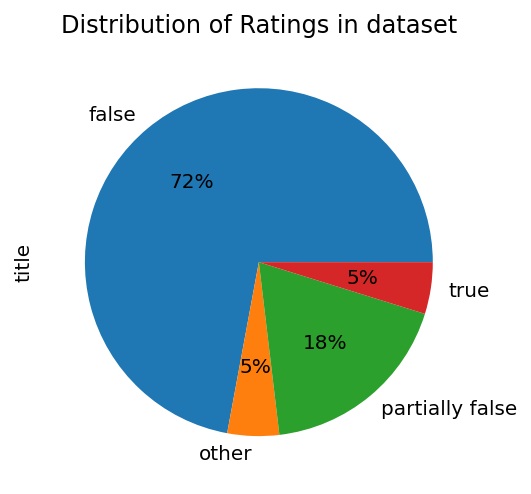

In [16]:
sentiment_class = df[['title', 'our rating']].groupby(by='our rating').count()['title']
ax = sentiment_class.plot(kind='pie',autopct='%1.0f%%')
ax.set_title('Distribution of Ratings in dataset')

df['our rating'].value_counts()

In [17]:
# Encode ratings to integers
le = LabelEncoder()
df['target'] = le.fit_transform(df['our rating'])
df.head(10)

public_id                                               text  \
0  5a228e0e  Distracted driving causes more deaths in Canad...   
1  30c605a1  Missouri politicians have made statements afte...   
2  c3dea290  Home Alone 2: Lost in New York is full of viol...   
3  f14e8eb6  But things took a turn for the worse when riot...   
4  faf024d6  It’s no secret that Epstein and Schiff share a...   
5  c03ed5db  Nation  UPDATED 8:23 PM - K A B O O M! Governo...   
6  61bd9a69  November 23, 2019  The U.S. Food and Drug Admi...   
7  bb1999cc  Trump confirms this was a bombing, not an acci...   
8  c1dc1ac6  In a show of anti-American sentiment that will...   
9  f2182a54  FEMA camps, portable human cages, it's all rea...   

                                               title       our rating  target  
0  You Can Be Fined $1,500 If Your Passenger Is U...            false       0  
1      Missouri lawmakers condemn Las Vegas shooting  partially false       2  
2  CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...  partially false       2  
3  Obama’s Daughters Caught on Camera Burning US ...            false       0  
4  Leaked Visitor Logs Reveal Schiff’s 78 Visits ...            false       0  
5  K A B O O M! Governor and Secretary of State i...            other       1  
6  FDA Shocking Study: Cells Used In Vaccines Con...            false       0  
7  Israel Hits Beirut with Nuclear Missile, Trump...            false       0  
8  Obama’s Daughters Caught on Camera Burning US ...            false       0  
9  Fields of human cages discovered in Caruthers ...            false       0

In [18]:
le.inverse_transform([0,1,2,3])

array(['false', 'other', 'partially false', 'true'], dtype=object)

In [19]:
df['tokenized'] = df['text'].map(lambda x: cleanText(x))

In [20]:
df['tokenized']

0      distract drive caus death canada impair drive ...
1      missouri politician made statement mass shoot ...
2      home alon lost new york full violenc opinion e...
3      thing took turn wors riot polic fire tear rubb...
4      secret epstein schiff share long histori perve...
                             ...                        
432    rosemari frei patrick corbett high-profil euro...
433    coronaviru pandem continu devast world way one...
434    belgium health minist maggi block put ban non-...
435    respond backlash netflix clarifi content pedop...
436    senat democrat fail taxpay local govern job se...
Name: tokenized, Length: 437, dtype: object

In [21]:
df[['tokenized', 'target']].to_csv("data_clean.csv", index=False)

In [22]:
data = pd.read_csv("data_clean.csv")
data.head()

tokenized  target
0  distract drive caus death canada impair drive ...       0
1  missouri politician made statement mass shoot ...       2
2  home alon lost new york full violenc opinion e...       2
3  thing took turn wors riot polic fire tear rubb...       0
4  secret epstein schiff share long histori perve...       0

In [23]:
# dropping indexes with nan
index_with_nan = data.index[data.isnull().any(axis=1)]
data.drop(index_with_nan,0, inplace=True)

# we have no nans left
pd.isna(data).sum()

tokenized    0
target       0
dtype: int64

In [24]:
# split text and labels

# text
text = data.iloc[:,0].copy().to_numpy()

# labels
y = data.iloc[:,1].copy().to_numpy().astype('int')

In [25]:
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.3, stratify=y)
print(len(text_train), len(text_test), len(y_train) + len(y_test))

303 131 434


In [259]:
import collections
# distributions train
c_train = collections.Counter(y_train)
c_train = dict(sorted(c_train.items()))

plt.figure(dpi=1200)
plt.pie(c_train.values(), labels=le.inverse_transform(list(c_train.keys())))
plt.savefig('data_dist_train.png')
plt.show()

In [260]:
# distributions train
c_test = collections.Counter(y_test)
c_test = dict(sorted(c_test.items()))

plt.figure(dpi=1200)
plt.pie(c_test.values(), labels=le.inverse_transform(list(c_test.keys())))
plt.savefig('data_dist_test.png')
plt.show()

In [26]:
dict(sorted(c_test.items()))

NameError: name 'c_test' is not defined

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# assigning the class to tfidf
tfidf = TfidfVectorizer(max_features=4000, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()
X_test = tfidf.transform(text_test).toarray()

In [28]:
X_train.shape, X_test.shape

((303, 1427), (131, 1427))

In [29]:
# calculating the optimal number of max features to consider:

accs = {k:0 for k in range(10, 3000, 50)}
for f in tqdm(range(10, 3000, 50)):

    # assigning the class to tfidf
    tfidf = TfidfVectorizer(max_features=f, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2',encoding='latin-1', ngram_range=(1, 3), stop_words='english')

    # applying the vectorizer to the training data
    X_train = tfidf.fit_transform(text_train).toarray()

    X_test = tfidf.transform(text_test).toarray()

    svm_model = LinearSVC(C=0.1)
    svm_model.fit(X_train, y_train)

    accs[f] = svm_model.score(X_test, y_test)

  7%|▋         | 4/60 [00:03<00:51,  1.08it/s]


KeyboardInterrupt: 

In [171]:
# features and max value
max(accs, key=accs.get), accs[max(accs, key=accs.get)]

(60, 0.732824427480916)

In [30]:
max_features = 360 # max(accs, key=accs.get)
tfidf = TfidfVectorizer(max_features=max_features, max_df=0.8, sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()
X_test = tfidf.transform(text_test).toarray()

In [31]:
label_dict = {'false': 0,

          'other': 1,
        'partially false': 2,
          'true': 3,}

In [32]:
N = 2
for category, id in label_dict.items():
    features_chi2 = chi2(X_train, y_train == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # single words
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # pair of words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # three words
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print('\n**',category,'\n')
    print("  +Most correlated unigrams:\n   -{}".format('\n   -'.join(unigrams[-N:])))
    print("  +Most correlated bigrams:\n   -{}".format('\n   -'.join(bigrams[-N:])))
    print("  +Most correlated trigrams:\n   -{}".format('\n   -'.join(trigrams[-N:])))


** false 

  +Most correlated unigrams:
   -wisconsin
   -border
  +Most correlated bigrams:
   -covid 19
   -presid trump
  +Most correlated trigrams:
   -

** other 

  +Most correlated unigrams:
   -immun
   -infect
  +Most correlated bigrams:
   -presid trump
   -joe biden
  +Most correlated trigrams:
   -

** partially false 

  +Most correlated unigrams:
   -governor
   -wisconsin
  +Most correlated bigrams:
   -joe biden
   -presid trump
  +Most correlated trigrams:
   -

** true 

  +Most correlated unigrams:
   -candid
   -money
  +Most correlated bigrams:
   -presid trump
   -covid 19
  +Most correlated trigrams:
   -


In [33]:
# applying an SVM model to it
svm = SVC()

params = {'C': [0.01, 0.1, 1, 10, 100],
         'kernel': ["linear", "poly", "rbf"],
         'gamma': ["scale", "auto"]
         }

svm_model = GridSearchCV(svm, param_grid=params)

%time svm_model.fit(X_train, y_train)

svm_model.best_params_, svm_model.score(X_test, y_test)

CPU times: user 1.77 s, sys: 16.4 ms, total: 1.78 s
Wall time: 2.18 s


({'C': 1, 'gamma': 'scale', 'kernel': 'linear'}, 0.7786259541984732)

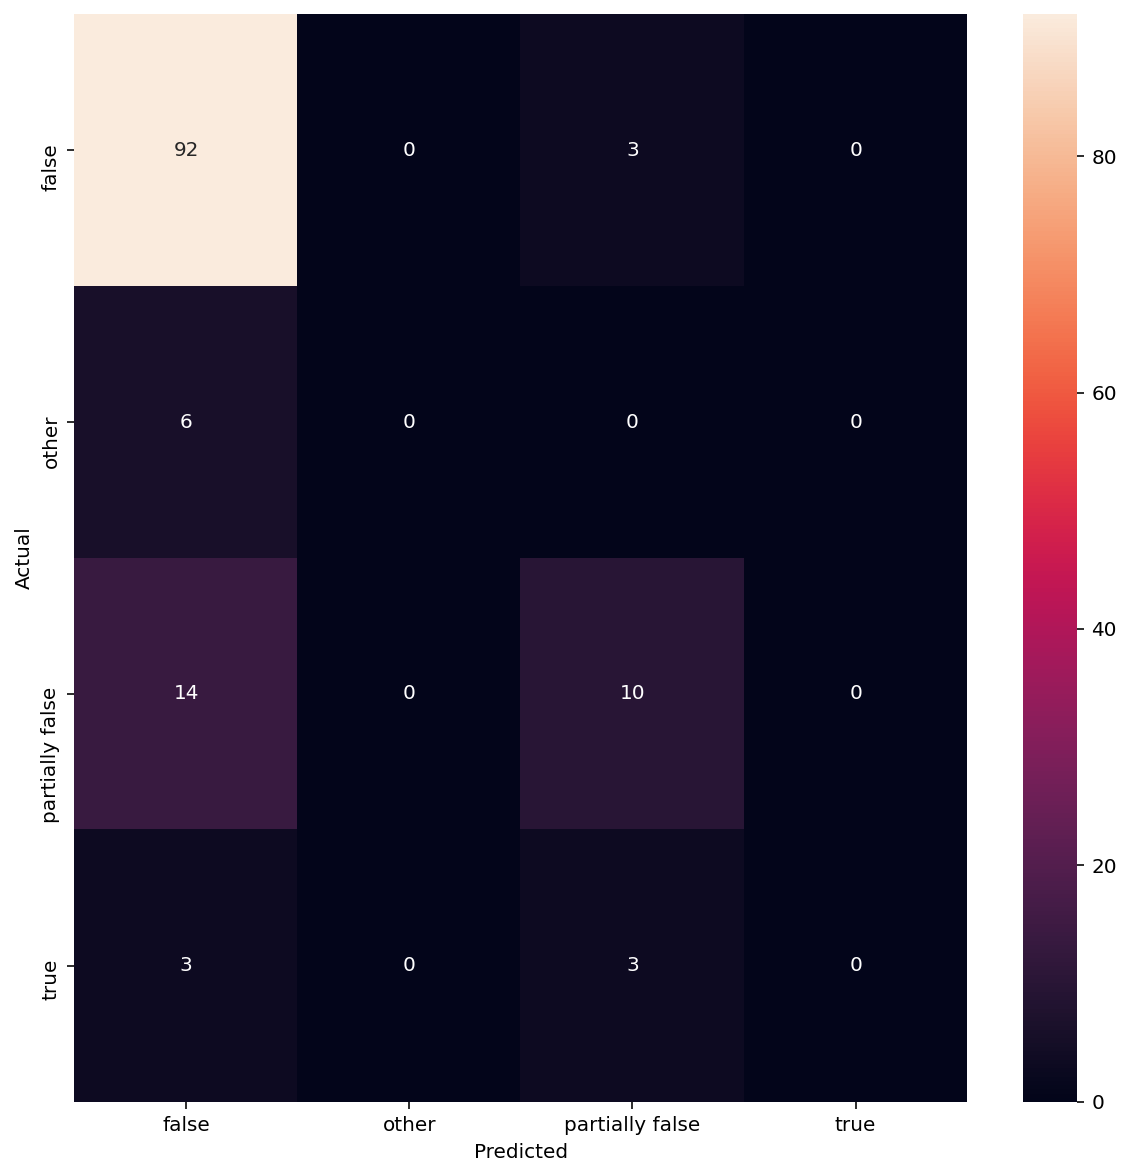

In [34]:
y_pred = svm_model.predict(X_test)

# generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_train)
Xtest_pca = pca.transform(X_test)
X_pca.shape, Xtest_pca.shape

((303, 100), (131, 100))

In [116]:
svc= LinearSVC()
svc.fit(X_pca, y_train)
svc.score(Xtest_pca, y_test)

0.7709923664122137

In [36]:
# simple lr with saga solver takes waay more time and gives the same result
lr = LogisticRegression() #solver='saga')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7709923664122137

In [37]:
# optimizing its parameters
params = {'C' : [1, 10, 25, 30],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'tol': [1e-4, 1e-3, 1e-2]
         }

lr_model = RandomizedSearchCV(lr, params, cv=3, n_jobs = -1)

%time lr_model.fit(X_train, y_train)
lr_model.best_params_, lr_model.score(X_test, y_test)

CPU times: user 106 ms, sys: 67.2 ms, total: 173 ms
Wall time: 2.8 s


/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.72277228 0.71617162 0.7359736  0.73267327        nan
 0.74917492        nan        nan 0.75577558]
  warnings.warn(


({'tol': 0.01, 'solver': 'newton-cg', 'penalty': 'l2', 'C': 10},
 0.7938931297709924)

In [38]:
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        95
           1       0.00      0.00      0.00         6
           2       0.62      0.54      0.58        24
           3       0.00      0.00      0.00         6

    accuracy                           0.79       131
   macro avg       0.36      0.37      0.37       131
weighted avg       0.71      0.79      0.75       131



/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [39]:
confusion_matrix(y_test, lr_model.predict(X_test))

array([[91,  0,  4,  0],
       [ 5,  0,  1,  0],
       [11,  0, 13,  0],
       [ 3,  0,  3,  0]])

In [46]:
lr_conf_mat_better = np.array([[83,  5,  4,  3],
                            [12, 12,  0,  0],
                            [ 5,  1,  0,  0],
                            [ 3,  3,  0,  0]])

lr_conf_mat_better

array([[83,  5,  4,  3],
       [12, 12,  0,  0],
       [ 5,  1,  0,  0],
       [ 3,  3,  0,  0]])

In [48]:
bert_conf_mat_better = np.array([[88,  7,  0,  0],
                            [12, 12,  0,  0],
                            [ 5,  1,  0,  0],
                            [ 4,  2,  0,  0]])

bert_conf_mat_better

array([[88,  7,  0,  0],
       [12, 12,  0,  0],
       [ 5,  1,  0,  0],
       [ 4,  2,  0,  0]])

In [41]:
lr_conf_mat = confusion_matrix(y_test, lr_model.predict(X_test))
lr_conf_mat[:,[1,2]] = lr_conf_mat[:,[2,1]]
lr_conf_mat[[1,2]]= lr_conf_mat[[2,1]] 

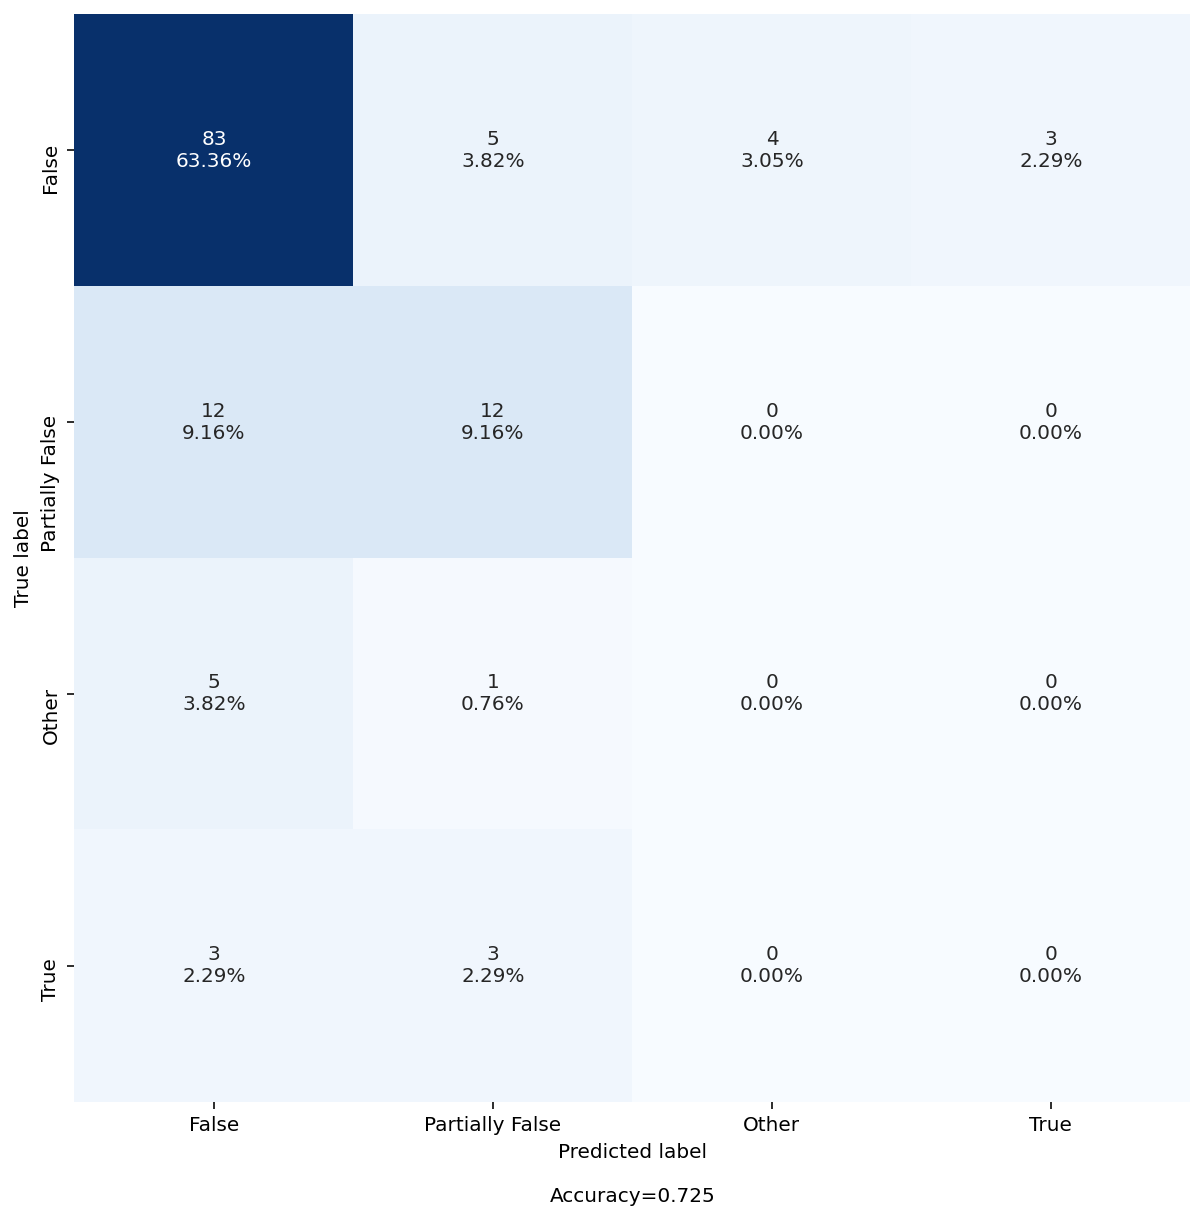

In [47]:
# my_array[:,[0, 1]] = my_array[:,[1, 0]]

make_confusion_matrix(lr_conf_mat_better, figsize=(10,10), cbar=False, categories=["False", "Partially False", "Other", "True"])

In [145]:
# simple gaussian naive bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.5572519083969466

In [177]:
# multinomial naive bayes model
params = {'alpha': [1e-6, 1e-5, 1e-4, 1e-2, 1],
         "fit_prior": [True, False]}

gnb_model = GridSearchCV(MultinomialNB(), params, cv=4, n_jobs = -1)

%time gnb_model.fit(X_train, y_train)

gnb_model.best_params_,gnb_model.score(X_test, y_test)

CPU times: user 40.3 ms, sys: 8.34 ms, total: 48.6 ms
Wall time: 125 ms


({'alpha': 1e-06, 'fit_prior': False}, 0.6564885496183206)

In [178]:
params = {'max_depth': [128,256, 400, 600],
          'min_samples_split': [50,100,200,400],
          'min_samples_leaf': [2,10]}
rf_model = RandomizedSearchCV(RandomForestClassifier(), params, cv = 3)
%time rf_model.fit(X_train, y_train)
rf_model.best_params_,rf_model.score(X_test, y_test)

CPU times: user 3.97 s, sys: 40.4 ms, total: 4.01 s
Wall time: 4.03 s


({'min_samples_split': 400, 'min_samples_leaf': 10, 'max_depth': 128},
 0.7251908396946565)

In [132]:
params = {'n_neighbors': range(1,20)}

knn_model = RandomizedSearchCV(KNeighborsClassifier(), params, cv=3, n_jobs = -1)

knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.7633587786259542

In [122]:
models = {'SVM': svm_model,
          'Logit': lr_model,
          'MultiNB': gnb_model,
          'RandomForest': rf_model}

In [273]:
# looping through the optimized models and getting all the accuracy metrics
for model_name, model in models.items():
    print('Classification Report of ', model_name, '\n')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names= label_dict.keys()))
    print('------------\n')

Classification Report of  SVM 

                 precision    recall  f1-score   support

          false       0.74      0.96      0.83        95
partially false       0.00      0.00      0.00         6
          other       0.25      0.08      0.12        24
           true       0.00      0.00      0.00         6

       accuracy                           0.71       131
      macro avg       0.25      0.26      0.24       131
   weighted avg       0.58      0.71      0.63       131

------------

Classification Report of  Logit 

                 precision    recall  f1-score   support

          false       0.72      0.83      0.77        95
partially false       0.00      0.00      0.00         6
          other       0.18      0.17      0.17        24
           true       0.00      0.00      0.00         6

       accuracy                           0.63       131
      macro avg       0.23      0.25      0.24       131
   weighted avg       0.56      0.63      0.59       131

--

/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=cleanText)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(msg_train.values.astype('U'),label_train)
predictions = pipeline.predict(msg_test.values.astype('U'))

print(classification_report(label_test, predictions))
print(f"Accuracy: {pipeline.score(msg_test.values.astype('U'), label_test)}")

/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

                 precision    recall  f1-score   support

          false       0.73      1.00      0.84        64
          other       0.00      0.00      0.00         4
partially false       0.00      0.00      0.00        16
           true       0.00      0.00      0.00         4

       accuracy                           0.73        88
      macro avg       0.18      0.25      0.21        88
   weighted avg       0.53      0.73      0.61        88

Accuracy: 0.7272727272727273


In [61]:
confusion_matrix(label_test, predictions)

array([[64,  0,  0,  0],
       [ 4,  0,  0,  0],
       [16,  0,  0,  0],
       [ 4,  0,  0,  0]])

## BERT

In [179]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [180]:
df = pd.read_csv("TFM_Batch_1.csv", sep=";")
df.head()

public_id                                               text  \
0  5a228e0e  Distracted driving causes more deaths in Canad...   
1  30c605a1  Missouri politicians have made statements afte...   
2  c3dea290  Home Alone 2: Lost in New York is full of viol...   
3  f14e8eb6  But things took a turn for the worse when riot...   
4  faf024d6  It’s no secret that Epstein and Schiff share a...   

                                               title       our rating  
0  You Can Be Fined $1,500 If Your Passenger Is U...            false  
1      Missouri lawmakers condemn Las Vegas shooting  partially false  
2  CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...  partially false  
3  Obama’s Daughters Caught on Camera Burning US ...            false  
4  Leaked Visitor Logs Reveal Schiff’s 78 Visits ...            false

In [181]:
df['our rating'].value_counts()

false              315
partially false     80
other               21
true                21
Name: our rating, dtype: int64

In [182]:
df.text.isna().sum()

3

In [183]:
df = df.dropna()
df.text.isna().sum()

0

In [184]:
df['our rating'].value_counts()

false              314
partially false     79
true                21
other               20
Name: our rating, dtype: int64

In [185]:
possible_labels = df['our rating'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'false': 0, 'partially false': 1, 'other': 2, 'true': 3}

In [186]:
df['label'] = df['our rating'].replace(label_dict)
df = df.copy()[['text', 'our rating', 'label']]
df

text       our rating  label
0    Distracted driving causes more deaths in Canad...            false      0
1    Missouri politicians have made statements afte...  partially false      1
2    Home Alone 2: Lost in New York is full of viol...  partially false      1
3    But things took a turn for the worse when riot...            false      0
4    It’s no secret that Epstein and Schiff share a...            false      0
..                                                 ...              ...    ...
432  Rosemary Frei and Patrick Corbett  A high-prof...            false      0
433  As the coronavirus pandemic continues to devas...            false      0
434  Belgium Health Minister Maggie de Block has pu...            false      0
435  Responding To Backlash, Netflix Clarifies Its ...            false      0
436  Senate Democrats Fail Taxpayers, Local Governm...  partially false      1

[434 rows x 3 columns]

In [187]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['our rating', 'label', 'data_type']).count()

text
our rating      label data_type      
false           0     train       219
                      val          95
other           2     train        14
                      val           6
partially false 1     train        55
                      val          24
true            3     train        15
                      val           6

In [188]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df['data_type'] == 'train'].text.copy().to_numpy(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df['data_type'] == 'val'].text.copy().to_numpy(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [189]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [190]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [192]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [193]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [194]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [195]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.932814302944368
Validation loss: 0.9492249957152775
F1 Score (Weighted): 0.6096737147875431



Epoch 2
Training loss: 0.8117466203628048
Validation loss: 0.8214916608163289
F1 Score (Weighted): 0.6096737147875431



Epoch 3
Training loss: 0.6769745941123655
Validation loss: 0.7147691760744367
F1 Score (Weighted): 0.7161927575672582



Epoch 4
Training loss: 0.5448115722786996
Validation loss: 0.726126637841974
F1 Score (Weighted): 0.7223925355309078



Epoch 5
Training loss: 0.47841814160346985
Validation loss: 0.6972650587558746
F1 Score (Weighted): 0.7212406369783227



Epoch 6
Training loss: 0.40029813661690683
Validation loss: 0.7642367822783334
F1 Score (Weighted): 0.7252649521974357



Epoch 7
Training loss: 0.32451183384945315
Validation loss: 0.7676645889878273
F1 Score (Weighted): 0.7163571976280126



Epoch 8
Training loss: 0.28864123744349324
Validation loss: 0.7794316144926208
F1 Score (Weighted): 0.7223319862296064



Epoch 9
Training loss: 0.24031855538487434
Validation loss: 0.8253970720938274
F1 Score (Weighted): 0.6914977625690971



Epoch 10
Training loss: 0.20246570851773985
Validation loss: 0.9237263724207878
F1 Score (Weighted): 0.7030170846964741


KeyboardInterrupt: 

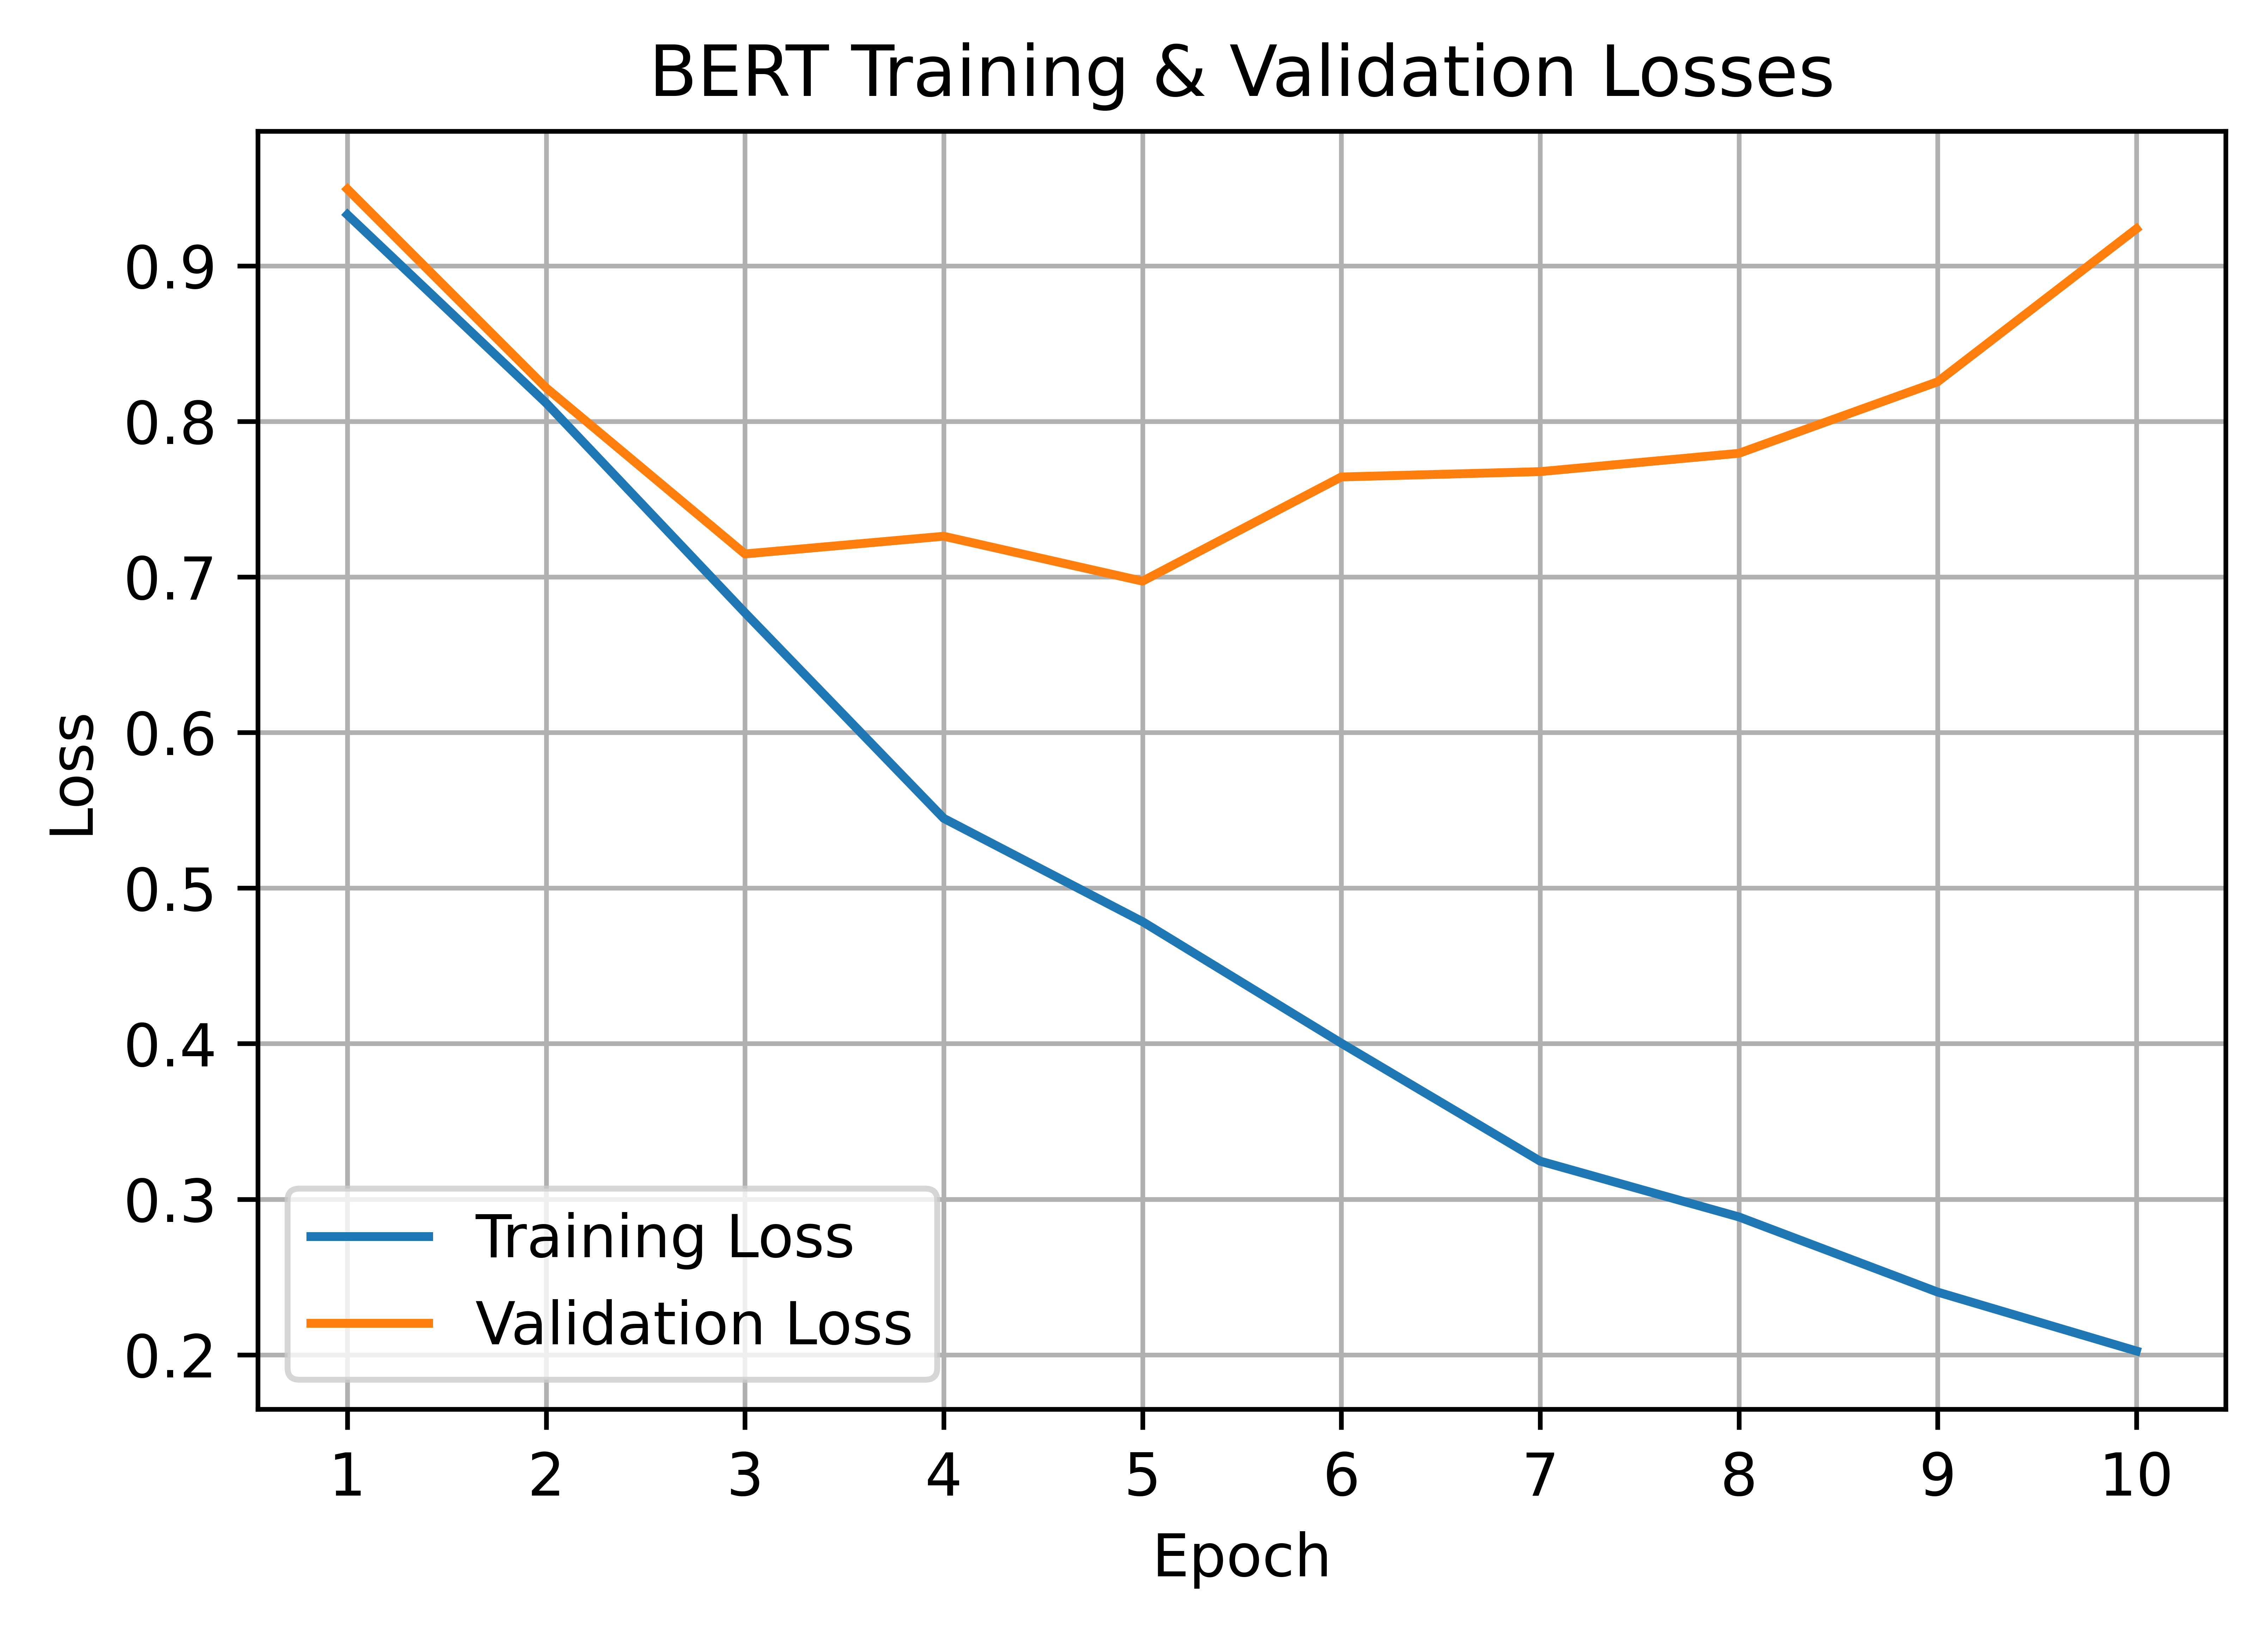

In [211]:
train_loss = [0.932814302944368,
             0.8117466203628048,
             0.6769745941123655,
             0.5448115722786996,
             0.47841814160346985,
             0.40029813661690683,
             0.32451183384945315,
             0.28864123744349324,
             0.24031855538487434,
             0.20246570851773985]

val_loss = [0.9492249957152775,
           0.8214916608163289,
           0.7147691760744367,
           0.726126637841974,
           0.6972650587558746,
           0.7642367822783334,
           0.7676645889878273,
           0.7794316144926208,
           0.8253970720938274,
           0.9237263724207878]

epochs = range(1,11)

plt.figure(dpi=1200)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.title('BERT Training & Validation Losses')
plt.grid()
plt.savefig('converge_bert.png')
plt.show()

In [142]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_10.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: false
Accuracy: 88/95

Class: partially false
Accuracy: 10/24

Class: other
Accuracy: 0/6

Class: true
Accuracy: 0/6



In [209]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: false
Accuracy: 88/95

Class: partially false
Accuracy: 12/24

Class: other
Accuracy: 0/6

Class: true
Accuracy: 0/6



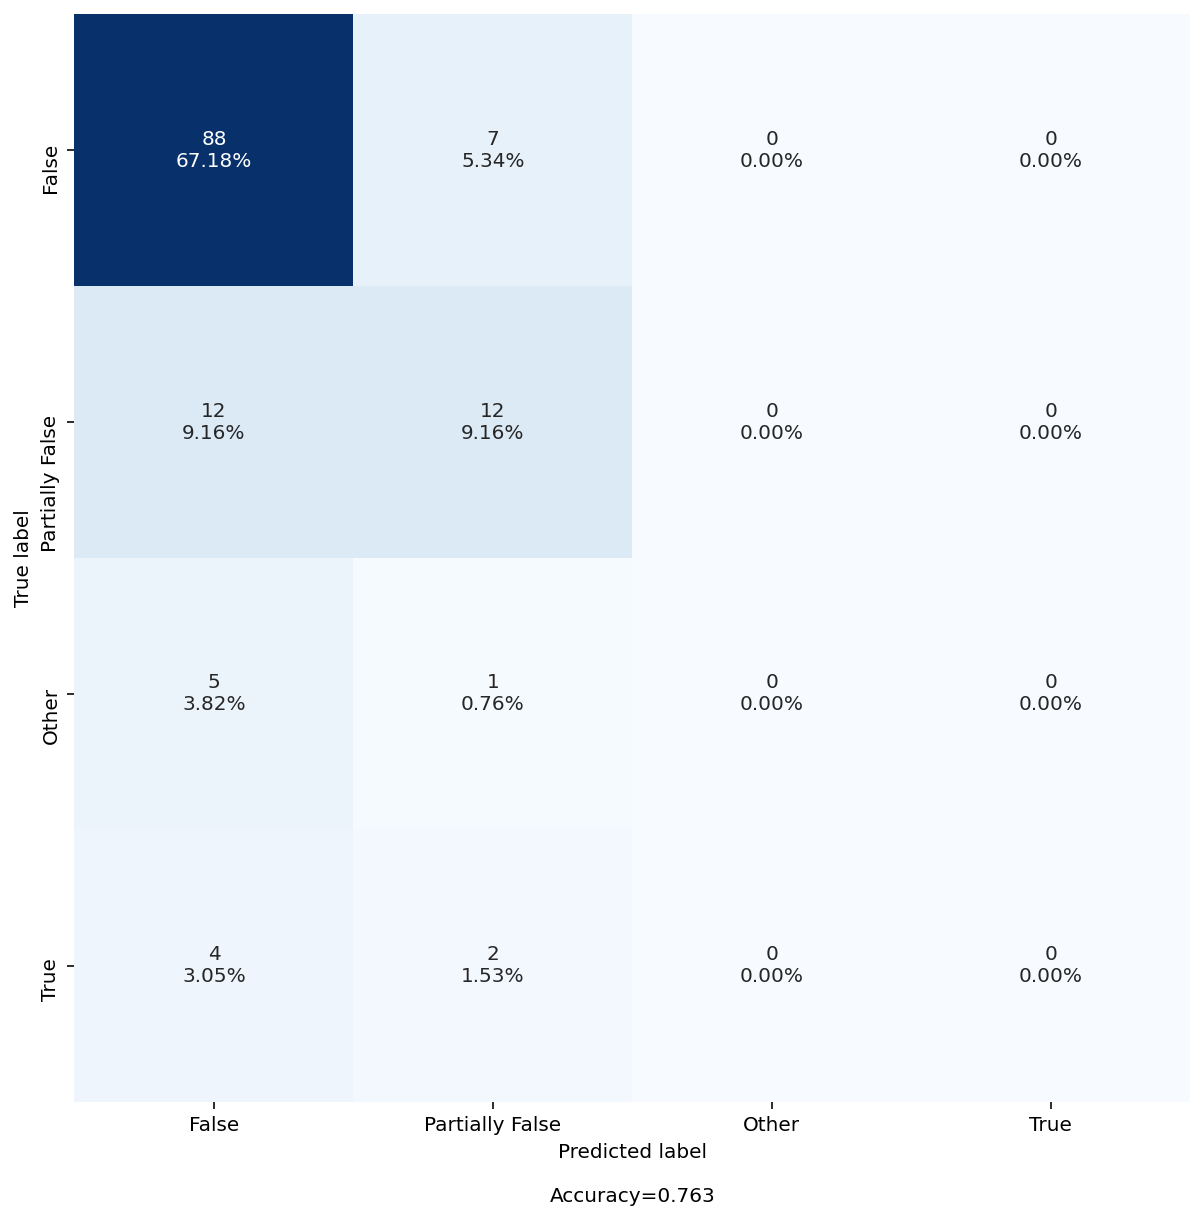

In [227]:
make_confusion_matrix(confusion_matrix(labels_val, preds), figsize=(10,10), cbar=False, categories=["False", "Partially False", "Other", "True"])

In [218]:
confusion_matrix(preds, labels_val)

array([[88, 12,  5,  4],
       [ 7, 12,  1,  2],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

In [212]:
preds = np.argmax(predictions, axis=1).flatten()
print(confusion_matrix(preds, labels_val))
print(classification_report(labels_val, preds))

[[88 12  5  4]
 [ 7 12  1  2]
 [ 0  0  0  0]
 [ 0  0  0  0]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        95
           1       0.55      0.50      0.52        24
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6

    accuracy                           0.76       131
   macro avg       0.34      0.36      0.35       131
weighted avg       0.69      0.76      0.72       131



/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/didierdirks/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

https://dl.acm.org/doi/10.1145/3395046
https://id.elsevier.com/as/authorization.oauth2?platSite=SD%2Fscience&scope=openid%20email%20profile%20els_auth_info%20els_idp_info%20els_sa_discover%20urn%3Acom%3Aelsevier%3Aidp%3Apolicy%3Aproduct%3Ainst_assoc&response_type=code&redirect_uri=https%3A%2F%2Fwww.sciencedirect.com%2Fuser%2Fidentity%2Flanding&authType=SINGLE_SIGN_IN&prompt=login&client_id=SDFE-v3&state=retryCounter%3D0%26csrfToken%3De74e100a-d1f4-4eb5-b0dd-b10eb09ce57a%26idpPolicy%3Durn%253Acom%253Aelsevier%253Aidp%253Apolicy%253Apr

In [299]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   TFM Didier Renzo Dirks.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	converge_bert.png
	data_dist_test.png
	data_dist_train.png
	finetuned_BERT_epoch_1.model
	finetuned_BERT_epoch_10.model
	finetuned_BERT_epoch_2.model
	finetuned_BERT_epoch_3.model
	finetuned_BERT_epoch_4.model
	finetuned_BERT_epoch_5.model
	finetuned_BERT_epoch_6.model
	finetuned_BERT_epoch_7.model
	finetuned_BERT_epoch_8.model
	finetuned_BERT_epoch_9.model

no changes added to commit (use "git add" and/or "git commit -a")


In [51]:
!git add --all

In [52]:
!git commit -m 'added bert models'

[main 9f269fa] added bert models
 15 files changed, 3263 insertions(+), 117 deletions(-)
 create mode 100644 .ipynb_checkpoints/TFM Didier Renzo Dirks-checkpoint.ipynb
 create mode 100644 converge_bert.png
 create mode 100644 data_dist_test.png
 create mode 100644 data_dist_train.png
 create mode 100644 finetuned_BERT_epoch_1.model
 create mode 100644 finetuned_BERT_epoch_10.model
 create mode 100644 finetuned_BERT_epoch_2.model
 create mode 100644 finetuned_BERT_epoch_3.model
 create mode 100644 finetuned_BERT_epoch_4.model
 create mode 100644 finetuned_BERT_epoch_5.model
 create mode 100644 finetuned_BERT_epoch_6.model
 create mode 100644 finetuned_BERT_epoch_7.model
 create mode 100644 finetuned_BERT_epoch_8.model
 create mode 100644 finetuned_BERT_epoch_9.model


In [55]:
!git push

Enumerating objects: 22, done.
Counting objects: 100% (22/22), done.
Delta compression using up to 4 threads
Compressing objects: 100% (20/20), done.
Writing objects: 100% (20/20), 3.77 GiB | 5.21 MiB/s, done.
Total 20 (delta 2), reused 0 (delta 0)
To gitlab.com:djrenzo/masterthesis.git
   d9b48ae..9f269fa  main -> main
